In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, espra, unit_det, fit_psi_params, psi_params

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None


In [2]:
def find_root(x, y):
    coeffs = np.polyfit(x, y, 3)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid = x[len(x)//2]
    return real_roots[np.argmin(np.abs(mid - real_roots))]

def tang_at_root(x, y, rx):
    coeffs = np.polyfit(x, y, 3)
    deriv = np.polyder(coeffs)
    slope = np.polyval(deriv, rx)
    intercept = np.polyval(coeffs, rx) - slope * rx
    return slope, intercept
    

In [3]:
width=500
x = np.linspace(-width // 2, width // 2, 101)
y = np.linspace(-width // 2, width // 2, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

xc, yc = 0.0, 0.0
Q11, Q12, Q22 = 1, .4, 1
psi0 = 250.0 
Rc = 85.0 
A = - psi0 / Rc**2

# rescale Q to have unit determinant
Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

dx, dy = X - xc, Y - yc
rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
Qr2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2 # ||Qr||
psi = psi0 * np.exp( - rho2 / Rc**2 )
u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2


               xc        yc         w       q11       q12       q22  \
Control  0.000000  0.000000 -0.000151  1.091089  0.436436  1.091089   
P1      -0.167131 -0.167131 -0.000144  1.089919  0.433501  1.089919   
P2       0.946608 -0.946608 -0.000132  1.094395  0.444635  1.094395   
P3      -5.285182 -5.285182 -0.000166  1.088537  0.430014  1.088537   
L1      -0.061639 -0.061639 -0.000147  1.091196  0.436702  1.091196   
L2      -0.167131 -0.167131 -0.000144  1.089919  0.433501  1.089919   
L3      -0.248601 -0.248601 -0.000141  1.088311  0.429444  1.088311   

                Rc        psi0         A  
Control  85.000000  250.000000 -0.034602  
P1       85.649101  252.264075 -0.034388  
P2       86.805676  256.060854 -0.033982  
P3       73.002764  223.607889 -0.041957  
L1       85.444923  251.494911 -0.034447  
L2       85.649101  252.264075 -0.034388  
L3       85.571920  252.306600 -0.034456  
                    xc             yc         w        q11        q12  \
Control       

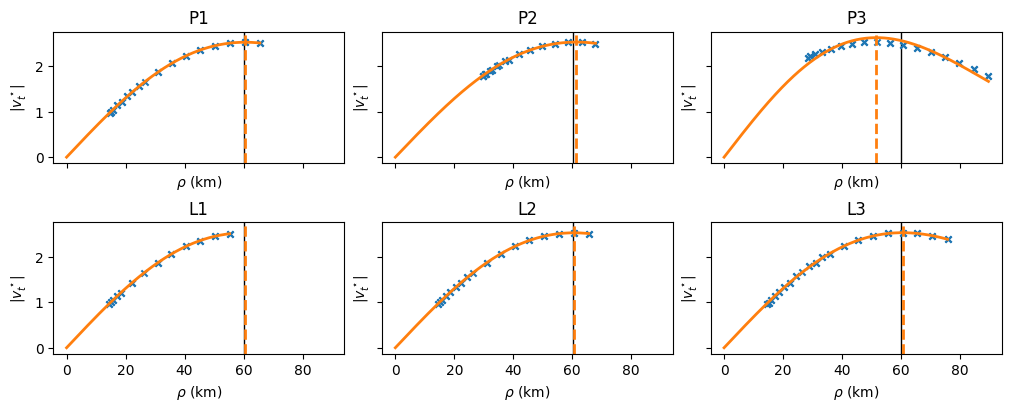

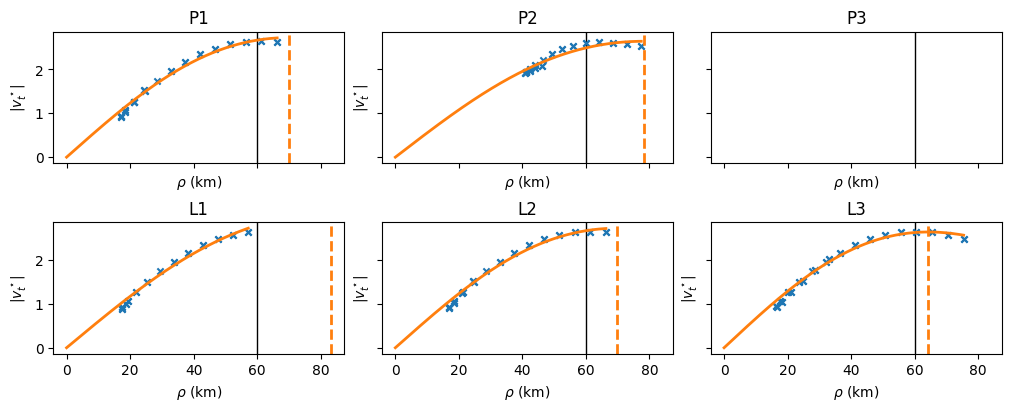

In [14]:
df_res_dop = pd.DataFrame({'xc': [xc], 'yc': [yc], 'w': [2*A*(q11+q22)*1e-3], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                        'Rc': [Rc], 'psi0': [psi0], 'A': [A]})
df_res_esp = pd.DataFrame({'xc': [xc], 'yc': [yc], 'w': [2*A*(q11+q22)*1e-3], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                        'Rc': [Rc], 'psi0': [psi0], 'A': [A]})

nic, njc = 53, 53
r = 8

df_tests = pd.DataFrame({
    'nic': [nic, 44, 43, nic, nic, nic],
    'njc': [njc, 56, 43, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(10, 4), sharey=True, sharex=True)
axs = axs.flatten()

fig, axs2 = plt.subplots(2, 3, constrained_layout=True, figsize=(10, 4), sharey=True, sharex=True)
axs2 = axs2.flatten()

dic_tests = {}
for t, test in enumerate(df_tests.index):
    data = df_tests.loc[test]

    x1 = x[data.nic-data.r:data.nic+data.r+1]
    y1 = np.array([y[data.njc]] * len(x1))

    u1 = u[data.nic-data.r:data.nic+data.r+1, data.njc]
    v1 = v[data.nic-data.r:data.nic+data.r+1, data.njc]

    y2 = y[data.njc-data.r:data.njc+data.r+1]
    x2 = np.array([x[data.nic]] * len(y2))

    u2 = u[data.nic, data.njc-data.r:data.njc+data.r+1]
    v2 = v[data.nic, data.njc-data.r:data.njc+data.r+1]

    points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
    common_points = points1 & points2
    # Remove duplicates from (x1, y1, u1, v1)
    mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
    x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
    # Concatenate with unaltered second set
    xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
    ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

    # DOPIOE
    xc_dop, yc_dop, w_dop, Q_dop, Rc_dop, psi0_dop, A_dop = dopioe(x1, y1, u1, v1, x2, y2, u2, v2, plot_flag=False)
    w_dop *= 1e-3
    
    df = psi_params(xc_dop, yc_dop, Q_dop, xi, yi, ui, vi)
    fit_psi_params(df.rho2, df.Qr, df.vt, r2_flag=True, 
                                     plot=True, Rc_max=1e6, ax=axs[t]) 
    
    dic_tests[test] = {'x1': x1, 'y1': y1, 'u1': u1, 'v1': v1,
                       'x2': x2, 'y2': y2, 'u2': u2, 'v2': v2,
                       'name': test}
    df_res_dop.loc[len(df_res_dop)] = {'xc': xc_dop, 'yc': yc_dop, 'w': w_dop,
                               'q11': Q_dop[0,0], 'q12': Q_dop[0,1], 'q22': Q_dop[1,1],
                               'Rc': Rc_dop, 'psi0': psi0_dop, 'A': A_dop}

    # ESPRA
    xc_esp, yc_esp, w_esp, Q_esp, Rc_esp, psi0_esp, A_esp = espra(xi, yi, ui, vi, plot_flag=False)
    w_esp *= 1e-3
    
    df = psi_params(xc_esp, yc_esp, Q_esp, xi, yi, ui, vi)
    fit_psi_params(df.rho2, df.Qr, df.vt, r2_flag=True, 
                                     plot=True, Rc_max=1e6, ax=axs2[t]) 
    
    df_res_esp.loc[len(df_res_esp)] = {'xc': xc_esp, 'yc': yc_esp, 'w': w_esp,
                               'q11': Q_esp[0,0], 'q12': Q_esp[0,1], 'q22': Q_esp[1,1],
                               'Rc': Rc_esp, 'psi0': psi0_esp, 'A': A_esp}
    

for a, ax in enumerate(axs):
    # if a%2==0:
    ax.set_title(df_tests.index[a])
    ax.set_xlabel(r'$\rho$ (km)')
    ax.axvline(Rc/np.sqrt(2), color='k', lw=1, zorder=-1) 

for a, ax in enumerate(axs2):
    # if a%2==0:
    ax.set_title(df_tests.index[a])
    ax.set_xlabel(r'$\rho$ (km)')
    ax.axvline(Rc/np.sqrt(2), color='k', lw=1, zorder=-1) 

df_res_dop.index = ['Control'] + list(df_tests.index)
df_res_esp.index = ['Control'] + list(df_tests.index)
print(df_res_dop)
print(df_res_esp)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


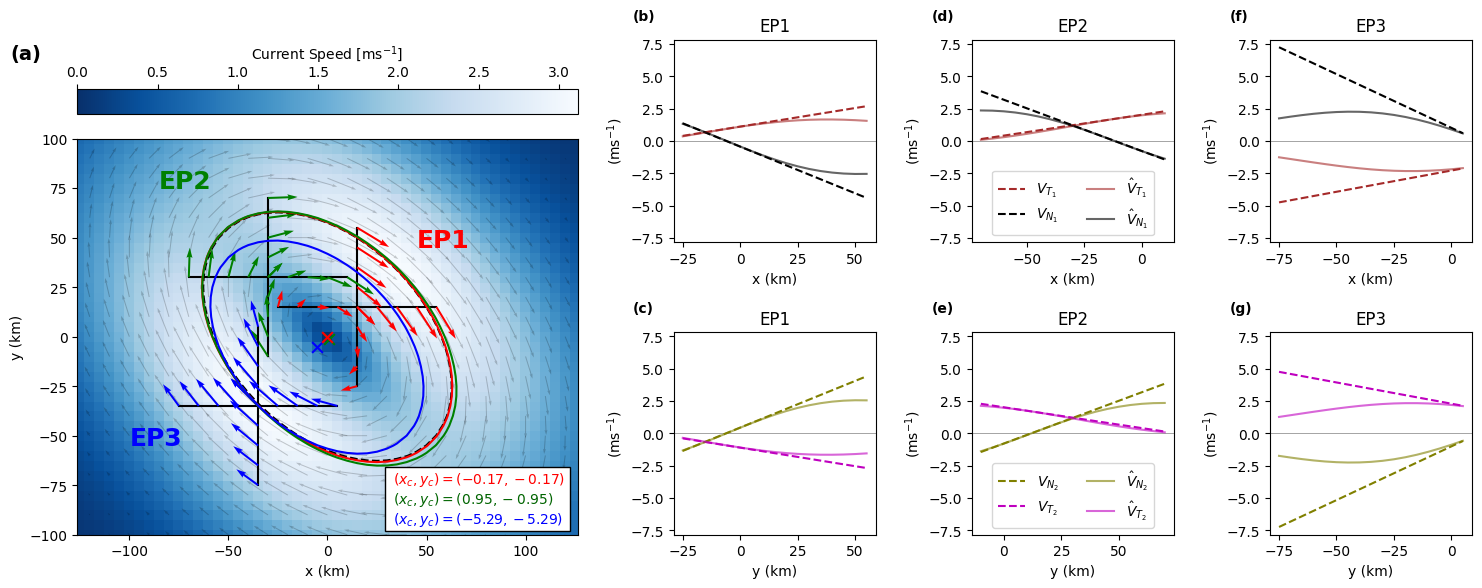

In [15]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'Blues_r'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='Current Speed [ms$^{-1}$]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

ax_main.contour(X, Y, rho2, levels=[Rc**2/2],
                     colors='k', linestyles='--')

# colours = ['r', 'darkgreen', 'b']
colours = ['r', 'g', 'b'] # limegreen
color = ['r', 'g', 'b']

i = 0
scales = [40, 58, 65]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, u1, v1, x2, y2, u2, v2 = (dic[k] for k in ['x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2'])
        data = df_res_dop.loc[dic['name']]
 
        ax_main.plot(x1, y1, 'k', zorder=1)
        ax_main.plot(x2, y2, 'k', zorder=1)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(data.xc, data.yc, marker='x', s=60, color=colours[i], zorder=10-extract_number(dic['name']))

        dx_ell, dy_ell = X - data.xc, Y - data.yc
        rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
        ax_main.contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors=colours[i])


        ax_main.text(33, -74 - 10*i, fr'$(x_c,y_c)=({data.xc:.2f},{data.yc:.2f})$', color='darkgreen' if '2' in dic['name'] else colours[i], zorder=11)
        i += 1

x_pos, y_pos = 0.80, 0.09
box_width = 0.37  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black', zorder=10)
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)', 'EP1'), ('(f)','(g)', 'EP3'), ('(d)','(e)', 'EP2')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, u1, v1, x2, y2, u2, v2 = (dic[k] for k in ['x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2'])
        data = df_res_dop.loc[dic['name']]
        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(x1, v1)
        A1, A0 = tang_at_root(x1, u1, root_x)
        B1, B0 = tang_at_root(x1, v1, root_x)
        p_u1 = A1*x1 + A0
        p_v1 = B1*x1 + B0

        root_y = find_root(y2, u2)
        C1, C0 = tang_at_root(y2, u2, root_y)
        D1, D0 = tang_at_root(y2, v2, root_y)
        p_u2 = C1*y2 + C0
        p_v2 = D1*y2 + D0
    
        ax2.plot(x1, p_u1, linestyle='--', color='brown', label=r'$V_{T_1}$')
        ax2.plot(x1, p_v1, 'k--', label=r'$V_{N_1}$')
        ax2.plot(x1, u1, color='brown', label=r'$\hat{V}_{T_1}$', alpha=.6)#, color=colours[i])
        ax2.plot(x1, v1, 'k', label=r'$\hat{V}_{N_1}$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(ms$^{-1}$)')
        ax2.set_xlabel(r'x (km)')
        if '2' in dic['name']:
            ax2.legend(loc='lower center', ncol=2)
        ax2.set_title(tags[2-j][2])
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')#, color=colours[i])
        
        ax3.plot(y2, p_u2, linestyle='--', color='olive', label=r'$V_{N_2}$')
        ax3.plot(y2, p_v2, 'm--', label=r'$V_{T_2}$')
        ax3.plot(y2, u2, color='olive', label=r'$\hat{V}_{N_2}$', alpha=.6)#, color=colours[i])
        ax3.plot(y2, v2, 'm', label=r'$\hat{V}_{T_2}$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(ms$^{-1}$)')
        ax3.set_xlabel(r'y (km)')
        if '2' in dic['name']:
            ax3.legend(loc='lower center', ncol=2)
        ax3.set_title(tags[2-j][2])
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')#, color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

ax_main.text(45, 45, 'EP1', color=color[0], zorder=3, fontsize=18, fontweight='bold')
ax_main.text(-85, 75, 'EP2', color=color[1], zorder=3, fontsize=18, fontweight='bold')
ax_main.text(-100, -55, 'EP3', color=color[2], zorder=3, fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()


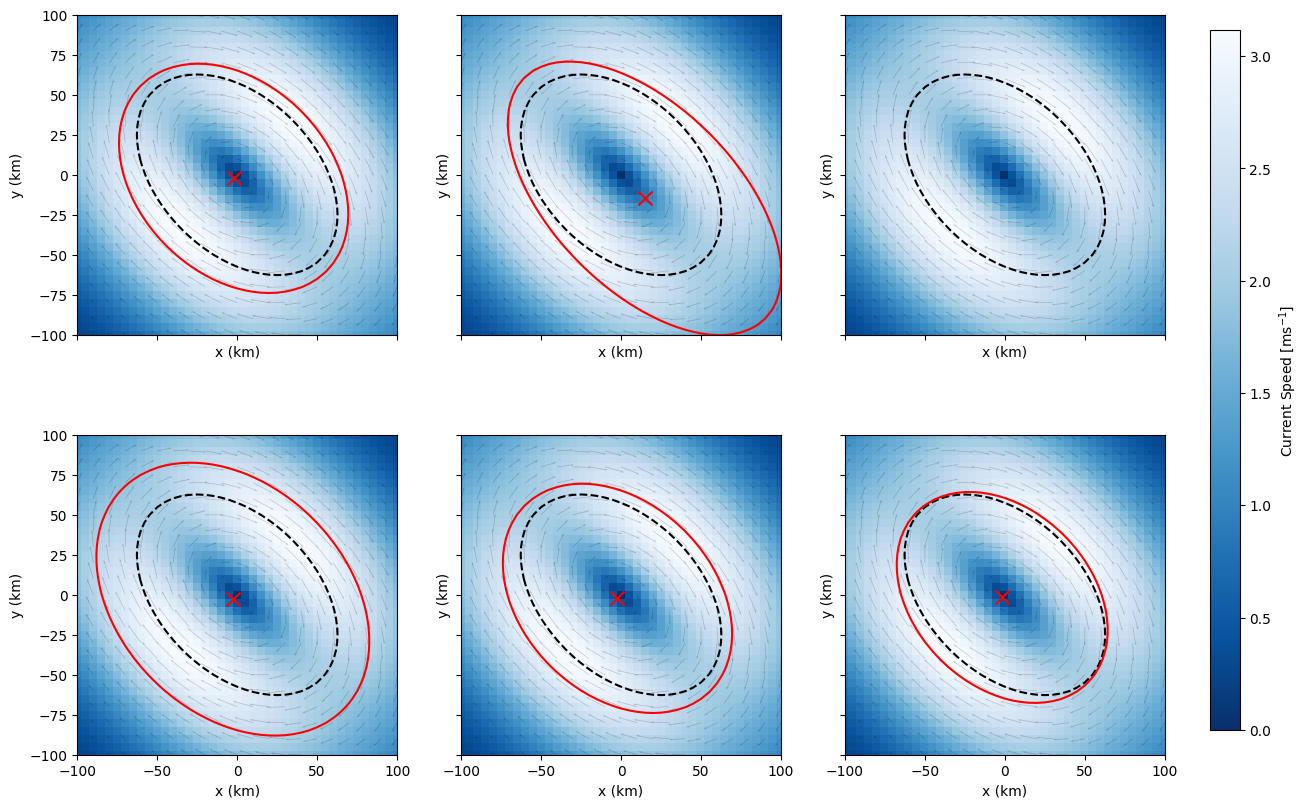

In [16]:
clr = 'm'
scat_scale = .75

fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=False, sharey=True, sharex=True)

cmap = 'Blues_r'
spacing, scale, width = 2, 40, 0.002 #0.004

# ---- plot background pcolor + quiver on each axis ----
for ax in axs.flatten():
    pc = ax.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
    ax.quiver(
        x[::spacing], y[::spacing],
        u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
        alpha=0.2, scale=scale, width=width, zorder=1
    )
    ax.contour(X, Y, rho2, levels=[df_res_esp.iloc[0].Rc**2/2],
                     colors='k', linestyles='--')
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

# ---- Panel 1: Example S-ADCP Data ----
data = df_res_esp.iloc[1]
dx_ell, dy_ell = X - data.xc, Y - data.yc
rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
axs[0,0].contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors='r')
axs[0,0].scatter(data.xc, data.yc, marker='x', s=100, color='r', zorder=10)
# axs[0,0].set_title('Ex1: S-ADCP Data')

# ---- Panel 2: Example Drifter Data ----
data = df_res_esp.iloc[2]
dx_ell, dy_ell = X - data.xc, Y - data.yc
rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
axs[0,1].contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors='r')
axs[0,1].scatter(data.xc, data.yc, marker='x', s=100, color='r', zorder=10)
# axs[0,1].set_title('Ex2: Drifter Data')

# ---- Panel 3: Example Transect Data ----
data = df_res_esp.iloc[3]
dx_ell, dy_ell = X - data.xc, Y - data.yc
rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
axs[0,2].contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors='r')
axs[0,2].scatter(data.xc, data.yc, marker='x', s=100, color='r', zorder=10)
# axs[0,2].set_title('Ex3: Transect Data')

# ---- Panel 1: Example S-ADCP Data ----
data = df_res_esp.iloc[4]
dx_ell, dy_ell = X - data.xc, Y - data.yc
rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
axs[1,0].contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors='r')
axs[1,0].scatter(data.xc, data.yc, marker='x', s=100, color='r', zorder=10)
# axs[0,0].set_title('Ex1: S-ADCP Data')

# ---- Panel 2: Example Drifter Data ----
data = df_res_esp.iloc[5]
dx_ell, dy_ell = X - data.xc, Y - data.yc
rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
axs[1,1].contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors='r')
axs[1,1].scatter(data.xc, data.yc, marker='x', s=100, color='r', zorder=10)
# axs[0,1].set_title('Ex2: Drifter Data')

# ---- Panel 3: Example Transect Data ----
data = df_res_esp.iloc[6]
dx_ell, dy_ell = X - data.xc, Y - data.yc
rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
axs[1,2].contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors='r')
axs[1,2].scatter(data.xc, data.yc, marker='x', s=100, color='r', zorder=10)
# axs[0,2].set_title('Ex3: Transect Data')

# ---- now place one colorbar to the right of the entire figure ----
# leave room on the right
fig.subplots_adjust(right=0.85)

# [left, bottom, width, height] in figure coords
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, orientation='vertical', label=r'Current Speed [ms$^{-1}$]')

plt.show()



In [17]:
df_res_dop


,xc,yc,w,q11,q12,q22,Rc,psi0,A
Control,0.000000,0.000000,-0.000151,1.091089,0.436436,1.091089,85.000000,250.000000,-0.034602
P1,-0.167131,-0.167131,-0.000144,1.089919,0.433501,1.089919,85.649101,252.264075,-0.034388
P2,0.946608,-0.946608,-0.000132,1.094395,0.444635,1.094395,86.805676,256.060854,-0.033982
P3,-5.285182,-5.285182,-0.000166,1.088537,0.430014,1.088537,73.002764,223.607889,-0.041957
L1,-0.061639,-0.061639,-0.000147,1.091196,0.436702,1.091196,85.444923,251.494911,-0.034447
L2,-0.167131,-0.167131,-0.000144,1.089919,0.433501,1.089919,85.649101,252.264075,-0.034388
L3,-0.248601,-0.248601,-0.000141,1.088311,0.429444,1.088311,85.571920,252.306600,-0.034456


In [18]:
df_res_esp


,xc,yc,w,q11,q12,q22,Rc,psi0,A
Control,0.000000,0.000000,-0.000151,1.091089,0.436436,1.091089,85.000000,250.000000,-0.034602
P1,-2.235363,-2.235363,-0.000104,1.051550,0.325205,1.051550,98.902125,313.987595,-0.032100
P2,14.723901,-14.723901,-0.000100,1.197516,0.658820,1.197516,110.540440,340.270606,-0.027847
P3,-193182.585933,-193183.231408,-0.000026,25.617454,-25.636878,25.617281,NaN,NaN,NaN
L1,-2.725186,-2.725186,-0.000110,1.051337,0.324515,1.051337,117.744022,417.744821,-0.030132
L2,-2.235363,-2.235363,-0.000104,1.051550,0.325205,1.051550,98.902125,313.987595,-0.032100
L3,-1.664127,-1.664126,-0.000097,1.051808,0.326038,1.051808,91.016454,279.826421,-0.033779


In [27]:
cols = ['xc','yc','w','q11','q12','q22','Rc','psi0','A']

ctrl_dop = df_res_dop.loc['Control', cols]
ctrl_esp = df_res_esp.loc['Control', cols]

err_dop = (df_res_dop[cols] - ctrl_dop).abs()
err_esp = (df_res_esp[cols] - ctrl_esp).abs()

improvement = (err_esp - err_dop) / err_esp
improvement = improvement.replace([np.inf, -np.inf], np.nan)

summary = improvement.loc[['P1','P2','P3','L1','L2','L3']]
# summary[summary.isna()] = np.inf
summary


,xc,yc,w,q11,q12,q22,Rc,psi0,A
P1,0.925233,0.925233,0.855962,0.970392,0.973614,0.970392,0.953309,0.964617,0.914541
P2,0.935709,0.935709,0.625592,0.968941,0.963131,0.968941,0.929301,0.932859,0.908180
P3,0.999973,0.999973,0.879348,0.999896,0.999754,0.999896,inf,inf,inf
L1,0.977382,0.977382,0.905214,0.997319,0.997620,0.997319,0.986412,0.991088,0.965399
L2,0.925233,0.925233,0.855962,0.970392,0.973614,0.970392,0.953309,0.964617,0.914541
L3,0.850612,0.850611,0.807234,0.929278,0.936663,0.929278,0.904941,0.922666,0.822605
